In [1]:
import math
import os
import dill as pickle
import random

import fasttext
from IPython.core.display import display, HTML
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Import the Data

In [2]:
df = pd.read_csv("test.csv")
df.head()

,Clause Text,Classification
0,"Cost-Benefit Ratio, which is the alternative’s...",0
1,Section 16 of the Agreement is modified in its...,0
2,“Professional Services” means the training or ...,0
3,(c) the Indemnified Party undertakes no action...,0
4,Assignment. Each Party will be entitled to ass...,0


In [3]:
df.shape

(1471, 2)

In [4]:
X_test = df['Clause Text']
y_test = df['Classification']

# Viz Functions

In [5]:
# functions for plotting classification results
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, y_scores, y_test, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("="*80)
    print("Operating point = {:.3f}".format(t),end="\n\n")
    print("Confusion Matrix:")
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_red', 'pred_gree'], 
                       index=['Compliant', 'Non-Compliant']),end="\n\n")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_adj, target_names=['Compliant', 'Non-Compliant']))
    
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold",fontdict=font)
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall',fontdict=font);
    plt.ylabel('Precision',fontdict=font);
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    recall_precision_delta = [abs(r - p) for r, p in zip(precisions, recalls)]
    min_delta = min(recall_precision_delta)
    min_delta_ix = recall_precision_delta.index(min_delta)
    optimal_threshold = thresholds[min_delta_ix]
    print(f"Optimal Operating Point: {optimal_threshold}")
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the operating point",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot((optimal_threshold, optimal_threshold), (0, 1), "r--", label="Optimal Operating Point")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Operating Point",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def plot_fpr_recall_vs_threshold(y_test, y_scores):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    
    fpr, tpr, roc_thresh = metrics.roc_curve(y_test, y_scores)
    p, r, prc_thresh = metrics.precision_recall_curve(y_test, y_scores)
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
   
    plt.figure(figsize=(8, 8))
    plt.title("False Positive and Recall Scores as a function of the operating point",fontdict=font)

    plt.plot(prc_thresh, r[:-1], "b--", label="Recall")
    plt.plot(roc_thresh, fpr, "g-", label="FPR")
    
    #plot vertical line where recall is highest (i.e. == 1)
    x_text = prc_thresh[0]
    plt.axvline(x=x_text)
    #plot horizontal line that will intersect where the vertical line hits the fpr line
    y_text = fpr[np.where(roc_thresh==find_nearest(roc_thresh, prc_thresh[0]))[0][0]]
    plt.axhline(y=y_text)
    x = round(x_text,2)
    y = round(y_text,2)
    plt.text(x_text,y_text,"({}, {})".format(x, y))
    plt.ylabel("Score")
    plt.xlabel("Operating Point")
    plt.legend(loc='best',fontsize=16)
    
def plot_prc(y_score, y_test):
    """
    Plot the precision-recall curve, labeled with average precision.
    """
    average_precision = metrics.average_precision_score(y_test, y_score)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    #plot it
    plt.figure(figsize=(8,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision),fontsize=20)
    
def plot_calibration_curve(y_true, y_prob):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob)
    bs = metrics.brier_score_loss(y_true, y_prob)
    fig = plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(mean_predicted_value, fraction_of_positives, label="%s (%1.3f)" % ("Brier Score", bs))

    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.title('Calibration plots  (reliability curve)')
    
    
def print_results(y_test, y_pred, y_score):
    
    f1 = metrics.f1_score(y_test, y_pred)
    bs = metrics.brier_score_loss(y_test, y_score)
    average_precision = metrics.average_precision_score(y_test, y_score)
    acc = metrics.accuracy_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
    auc = metrics.auc(recalls, precisions)
    recall = metrics.recall_score(y_test, y_pred)
    
    print("*"*80)
    print("Recall:  {0:.2f}".format(recall))
    print("Accuracy:  {0:.2f}".format(acc))
    print("F1:  {0:.2f}".format(f1))
    print("Brier Score:  {0:.2f}".format(bs))

    print("-"*80)
    print("Classification Report:")
    print(metrics.classification_report(
        y_test,
        y_pred,
        target_names=['Compliant', 'NonCompliant']
    ))

# Linear Model Visualizations

These visuals will help evaluate the performance of the linear model (Support Vector Machine or Logistic Regression) used by the Stochastic Gradient Descent learner.

In [30]:
# the loss='log' tells us it was logistic regression
model = joblib.load(os.path.join("estimators", "sgd.joblib"))
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.2306547259077263,
                  max_features=None, min_df=2, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=True,
                  token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function stemmer at 0x118b74488>, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=2457, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
                early_stopping=False, epsilon=0.04376496065433098, eta0=0.0,
                fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
           

In [31]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

## Classifcation Report

In [33]:
print_results(y_test, y_pred, y_score)

********************************************************************************
Recall:  0.76
Accuracy:  0.79
F1:  0.60
Brier Score:  0.15
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.93      0.80      0.86      1178
NonCompliant       0.49      0.76      0.60       293

    accuracy                           0.79      1471
   macro avg       0.71      0.78      0.73      1471
weighted avg       0.84      0.79      0.81      1471



## ROC Curve
ROC curves feature the true positive rate on the y-axis and the false positive rate on the x-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

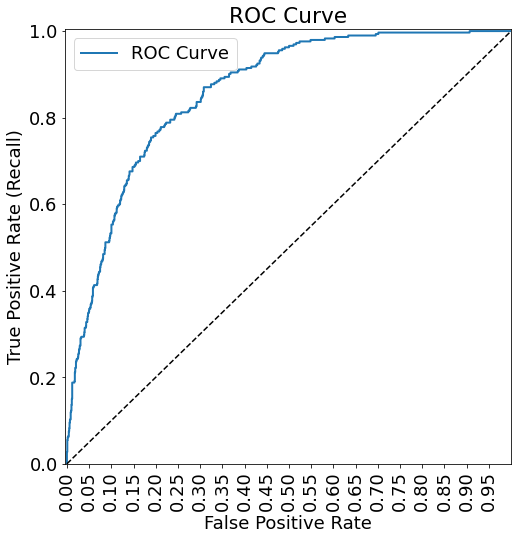

In [34]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
plot_roc_curve(fpr, tpr, 'ROC Curve')

Although this plot looks good, we should ignore it. For imbalanced classification problems like ours, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score. A common alternative is the precision-recall curve and area under curve.

## PRC AUC

**Precision** is a metric that quantifies the number of correct positive predictions made.

It is calculated as the number of true positives divided by the total number of true positives and false positives.

 - Precision = TruePositives / (TruePositives + FalsePositives)
 - The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.

**Recall** is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

It is calculated as the number of true positives divided by the total number of true positives and false negatives (e.g. it is the true positive rate).

 - Recall = TruePositives / (TruePositives + FalseNegatives)
 - The result is a value between 0.0 for no recall and 1.0 for full or perfect recall.
 
 
Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class).

A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models, so we'll use it.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


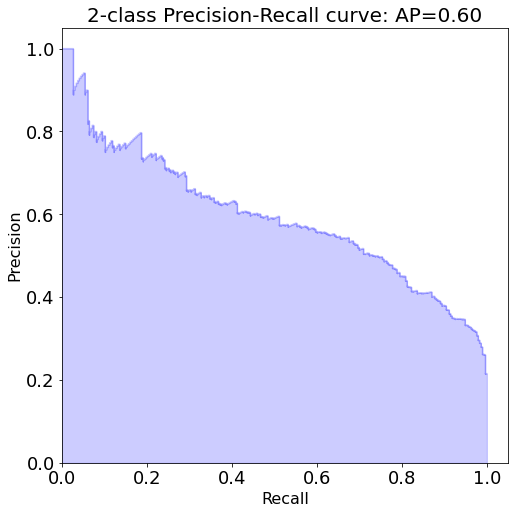

In [35]:
plot_prc(y_score, y_test)

## Threshold Adjusting

Since we're interested in tradeoffs between precision and recall, we can visualize the tradeoff when the probability threshold for the estimator's decision (50% by default) is adjusted. When treating the thresholding in such a fashion, it's referred to as the model's **operating point**.

Below, we'll look at operating points of $0.4 , 0.45, 0.5 , 0.55, 0.6$

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant           826        352
Non-Compliant        48        245

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.95      0.70      0.81      1178
Non-Compliant       0.41      0.84      0.55       293

     accuracy                           0.73      1471
    macro avg       0.68      0.77      0.68      1471
 weighted avg       0.84      0.73      0.75      1471

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant           889        289
Non-Compliant        56        237

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.94      0.75      0.84      1178
Non-Compliant       0.45      0.81      0.58       293

     accuracy                           0.77      1471
    macro avg       0.70      0.78      0.71      1471
 weighted avg       0.84      0.77      0.79  

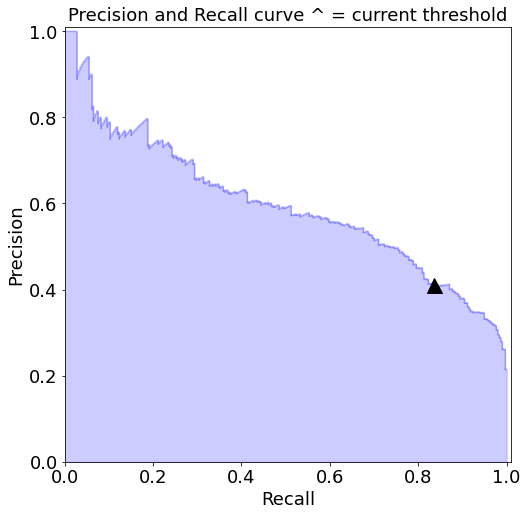

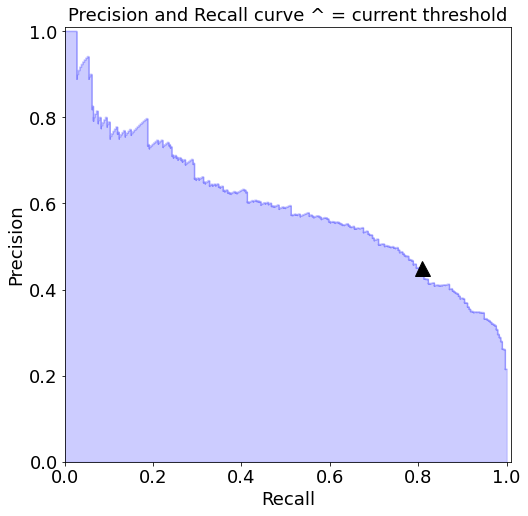

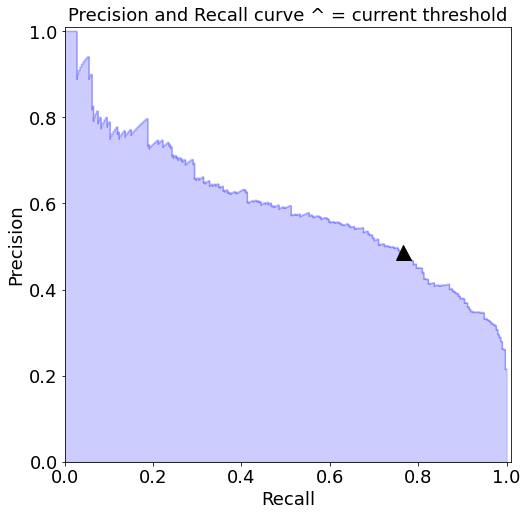

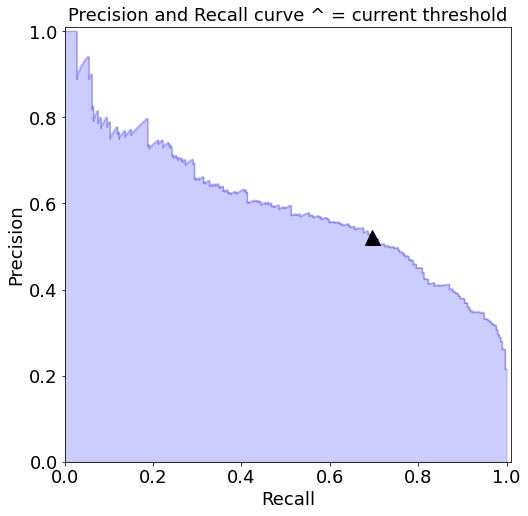

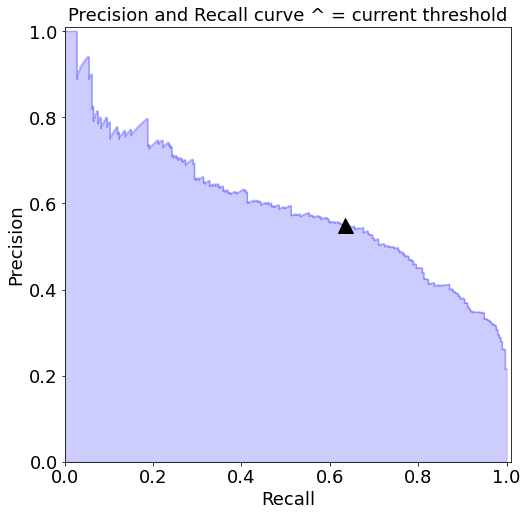

In [36]:
p, r, thresholds = metrics.precision_recall_curve(y_test, y_score)
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, y_score, y_test, t=i)

As the operating point increases, we see precision for the majority class - i.e. Compliant - decrease while precision for the minority class - i.e Non-Compliant - increases. The inverse happens to recall. The point of this exercise is to demonstrate that business values - e.g. a low false positive rate - can be prioritized by adjusting the operating point, but obviously with a cost.

To help make the optimal decision for choosing an operating point, it's possible to plot precision and recall as a function of the operating point. Finding the intersection of these two curves maximizes their values (assuming you value precision the same as recall).

Optimal Operating Point: 0.6295076625472615


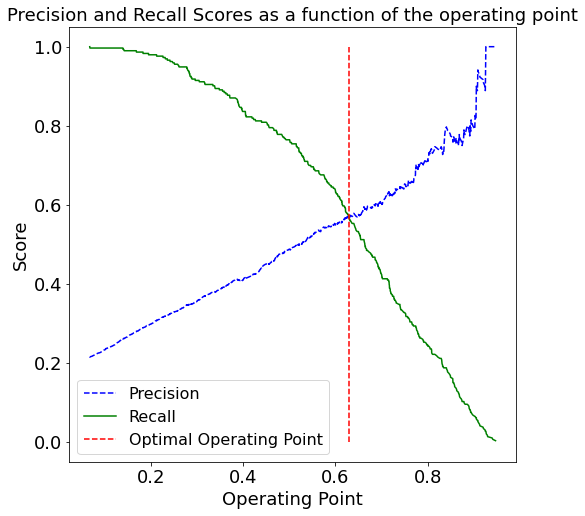

In [37]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve
Adjusting the operating point only makes sense if the model is properly calibrated.

In a calibration curve, the x-axis represents the average predicted probability in each bin. The y-axis is the fraction of positives, i.e. the proportion of samples whose class is the positive class (in each bin). In short, it's a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency (x-axis). For a perfect model, you'd expect to see a calibration curve that forms a 45-degree diaganol starting at the origin and moving north-east. When the line is below the diagonal, the model has predicted non-compliant when it should have predicted compliant (i.e. the probabilities are too large). When the line is above the diagonal, the model has predicted compliant when it should have predicted non-compliant (i.e. the probabilities are too small).

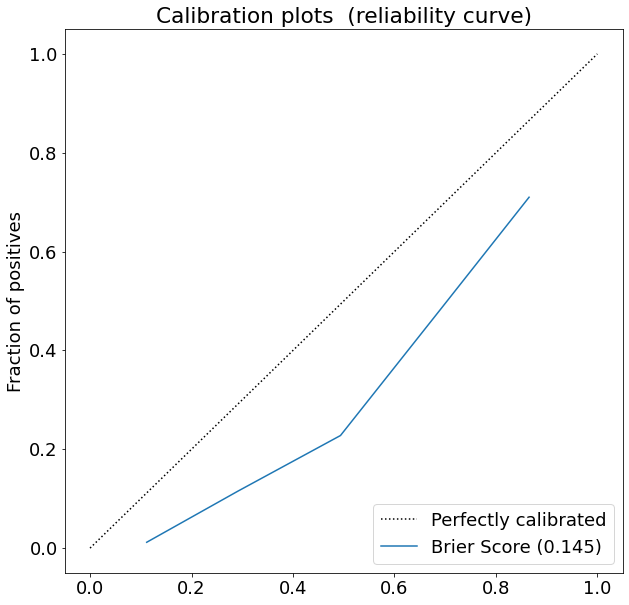

In [38]:
plot_calibration_curve(y_test, y_score)

Since this lies under the diagonal, the model is predicting non-compliant too frequently. Above, we saw that our optimal operating point was $.650921373070175$. If we change our operating point to $.62$, we'll increase precision for the positive class (i.e. Non-compliant) at the expense of precision for the negative class (i.e. Compliant). This will, however, lead to the inverse for recall. Let's see the calibration curve if we adjust the operating point.

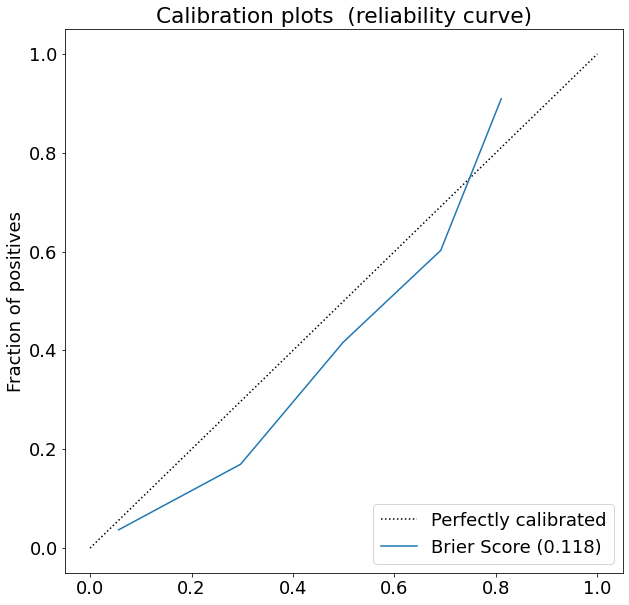

In [39]:
plot_calibration_curve(
    y_test,
    np.clip(y_score - .12, 0, 1) #  .12 = .65 - .5
)

In [40]:
metrics.f1_score(y_test, y_pred)

0.5957446808510638

In [41]:
adjusted_y_pred = [0 if i < .5 else 1 for i in np.clip(y_score - .12, 0, 1)]
metrics.f1_score(y_test, adjusted_y_pred)

0.5780730897009966

**The result brings the curve closer to the diagnol when it is below the line predicting compliant, but also brings it above the diagonal when it is predicting non-compliant. Thus the new operating point lowers the brier score and also lowers the f1-score**

# Gradient Boosting Classifier Visualizations

In [113]:
model = joblib.load(os.path.join("estimators", "gbc.joblib"))

In [114]:
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.1448027777838148,
                  max_features=None, min_df=1, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=True,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=792, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                             learning_rate=0.14732085238358114, loss='deviance',
                             max_depth=69, max_features='auto',
                             max_leaf_nodes=None, min_impurity_decrease

In [116]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

## Classification Report

In [117]:
print_results(y_test, y_pred, y_score)

********************************************************************************
Recall:  0.42
Accuracy:  0.83
F1:  0.49
Brier Score:  0.15
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.86      0.93      0.89      1178
NonCompliant       0.59      0.42      0.49       293

    accuracy                           0.83      1471
   macro avg       0.73      0.67      0.69      1471
weighted avg       0.81      0.83      0.81      1471



## ROC Curve

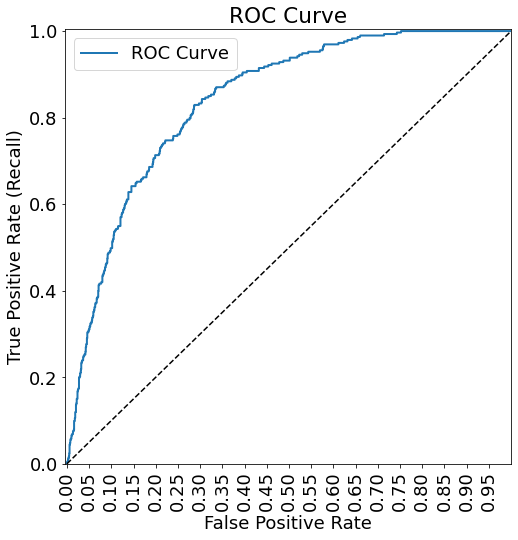

In [118]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
plot_roc_curve(fpr, tpr, 'ROC Curve')

## PRC AUC

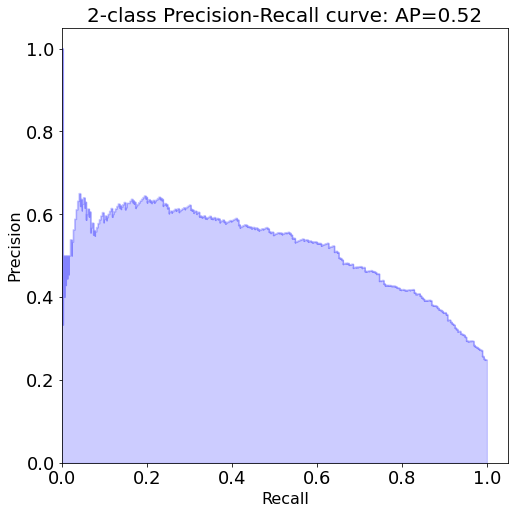

In [119]:
plot_prc(y_score, y_test)

## Threshold Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          1081         97
Non-Compliant       165        128

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.87      0.92      0.89      1178
Non-Compliant       0.57      0.44      0.49       293

     accuracy                           0.82      1471
    macro avg       0.72      0.68      0.69      1471
 weighted avg       0.81      0.82      0.81      1471

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          1087         91
Non-Compliant       170        123

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.86      0.92      0.89      1178
Non-Compliant       0.57      0.42      0.49       293

     accuracy                           0.82      1471
    macro avg       0.72      0.67      0.69      1471
 weighted avg       0.81      0.82      0.81  

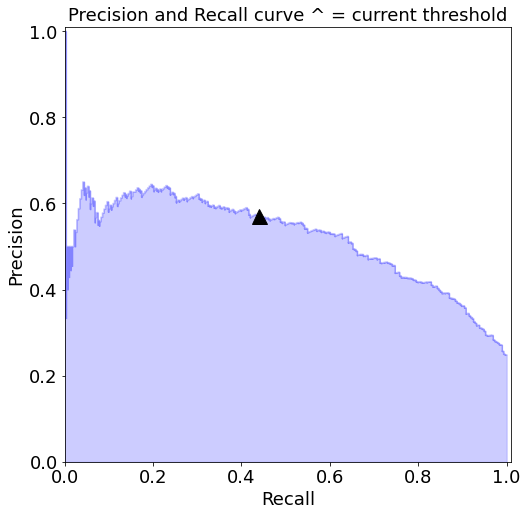

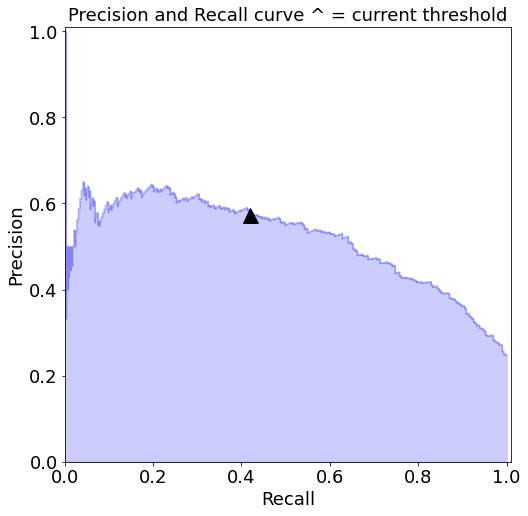

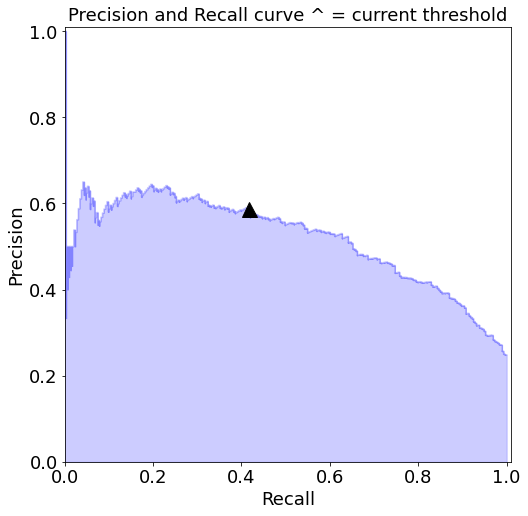

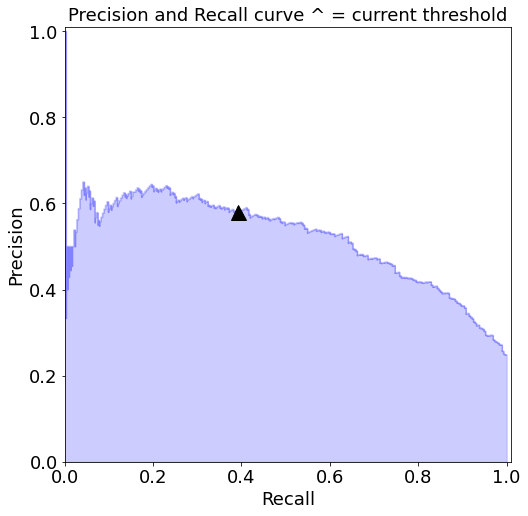

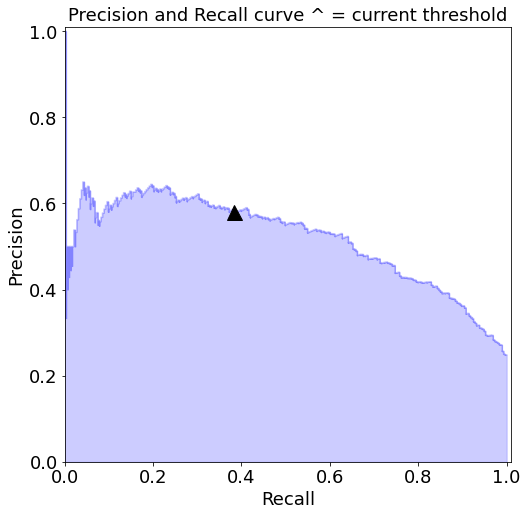

In [120]:
p, r, thresholds = metrics.precision_recall_curve(y_test, y_score)
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, y_score, y_test, t=i)

Optimal Operating Point: 0.135618202193124


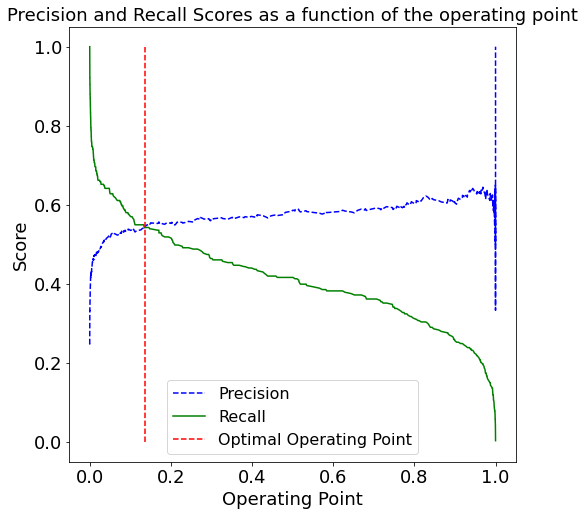

In [121]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

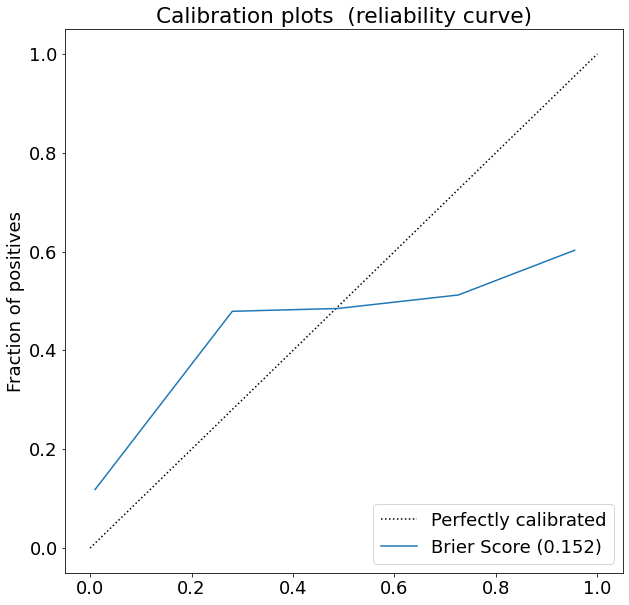

In [122]:
plot_calibration_curve(y_test, y_score)

# Random Forest Visualizations

In [104]:
model = joblib.load(os.path.join("estimators", "rfc.joblib"))
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.1424292112356325,
                  max_features=None, min_df=2, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=False,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=2264, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                         criterion='gini', max_depth=50, max_features=None,
                         max_leaf_nodes=None, min_impurity_decrease=0.0,
                         min_impurity_split=None,
               

In [105]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:, 1]

## Classification Report

In [106]:
print_results(y_test, y_pred, y_score)

********************************************************************************
Recall:  0.70
Accuracy:  0.78
F1:  0.56
Brier Score:  0.15
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.91      0.80      0.85      1178
NonCompliant       0.47      0.70      0.56       293

    accuracy                           0.78      1471
   macro avg       0.69      0.75      0.71      1471
weighted avg       0.83      0.78      0.80      1471



## ROC Curve

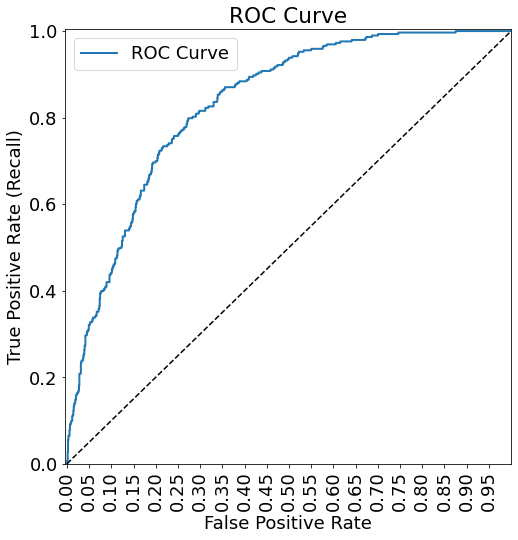

In [107]:
fpr, tpr, auc_thresholds = metrics.roc_curve(y_test, y_score)
plot_roc_curve(fpr, tpr, 'ROC Curve')

## PRC AUC

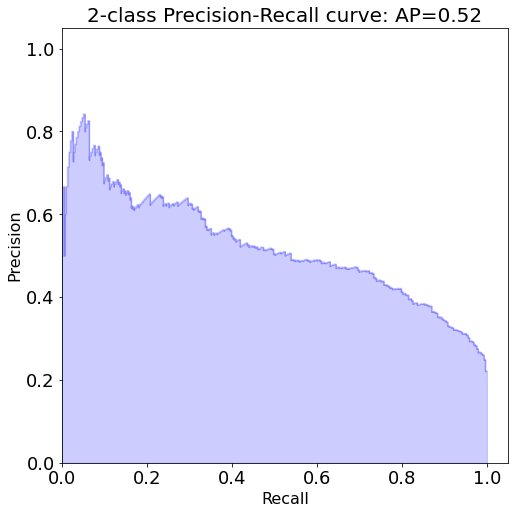

In [108]:
plot_prc(y_score, y_test)

## Threshold Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant           755        423
Non-Compliant        38        255

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.95      0.64      0.77      1178
Non-Compliant       0.38      0.87      0.53       293

     accuracy                           0.69      1471
    macro avg       0.66      0.76      0.65      1471
 weighted avg       0.84      0.69      0.72      1471

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant           853        325
Non-Compliant        59        234

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.94      0.72      0.82      1178
Non-Compliant       0.42      0.80      0.55       293

     accuracy                           0.74      1471
    macro avg       0.68      0.76      0.68      1471
 weighted avg       0.83      0.74      0.76  

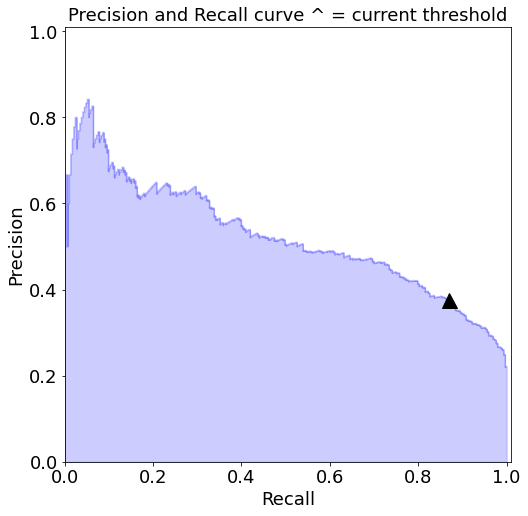

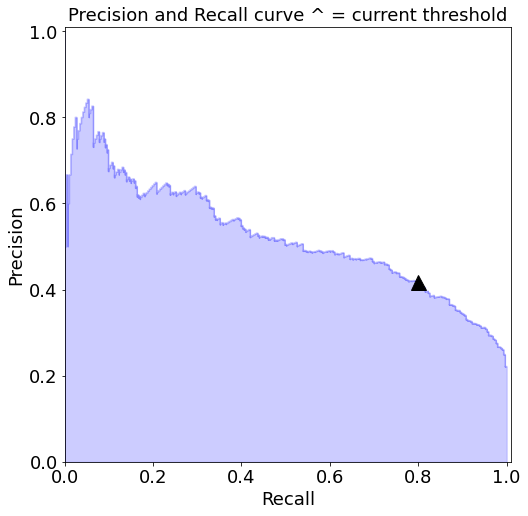

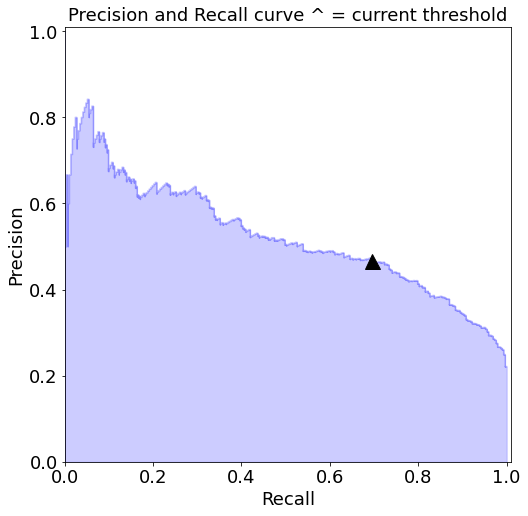

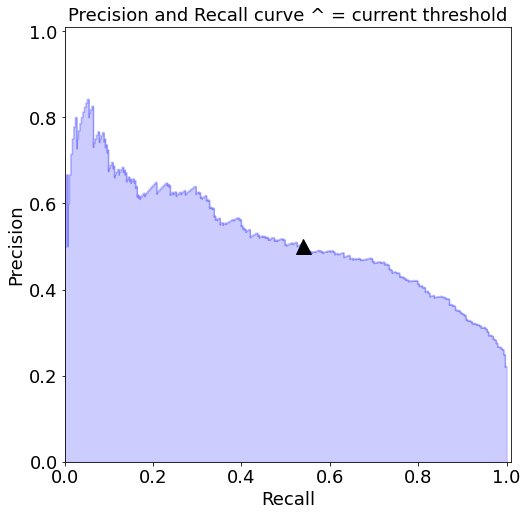

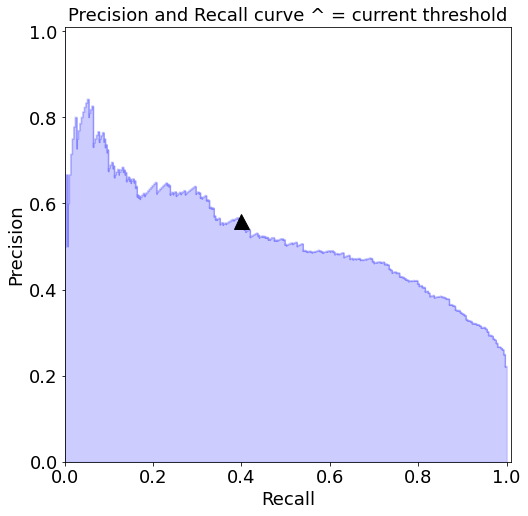

In [109]:
p, r, thresholds = metrics.precision_recall_curve(y_test, y_score)
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, y_score, y_test, t=i)

Optimal Operating Point: 0.5588619578201964


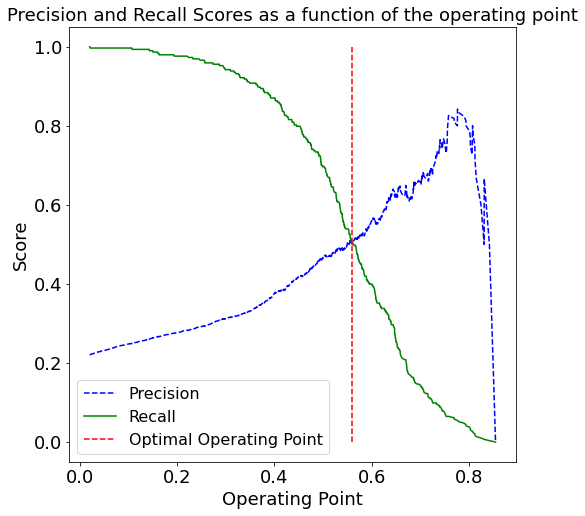

In [110]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

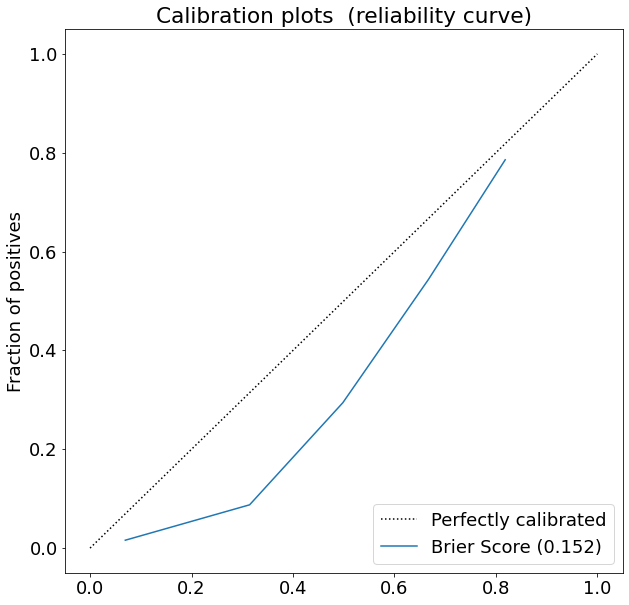

In [111]:
plot_calibration_curve(y_test, y_score)

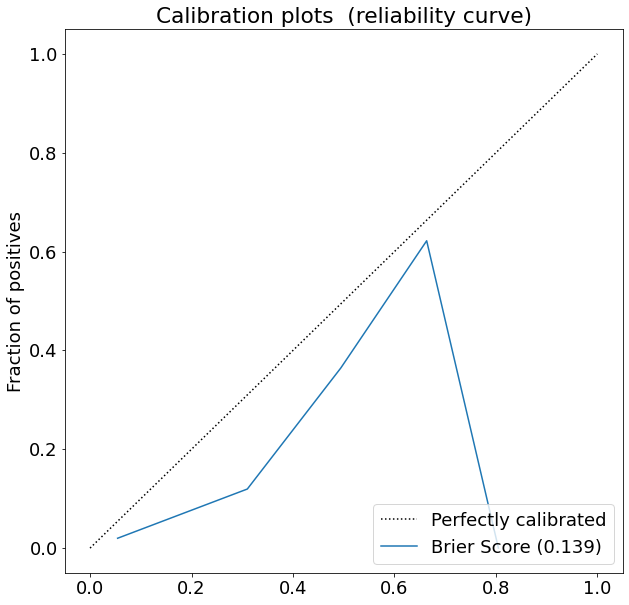

In [112]:
plot_calibration_curve(
    y_test,
    np.clip(y_score - .05, 0, 1)
)

# Blazing Text (Word Embedding Model)

In [54]:
model = fasttext.load_model(os.path.join("estimators", "model.bin"))

In [57]:
bt_X_test = X_test.apply(lambda x: ' '.join(nltk.word_tokenize(x.lower())))

In [59]:
preds, probs = model.predict([c for c in bt_X_test.tolist()])
preds = [p[0][-1] for p in preds]
probs = [p[0] for p in probs]

In [60]:
def fix_prob(prob):
    # to get probability of positive class
    if prob < 0:
        return 0
    elif prob > 1:
        return 1
    else:
        return prob

In [63]:
parsed_preds = []
for pred, prob in zip(preds, probs):
    parsed_pred = {}
    if pred == '0':
        prob = 1 - prob
    parsed_pred['y_pred'] = pred
    parsed_pred['y_score'] = fix_prob(prob)
    parsed_preds.append(parsed_pred)

In [64]:
bt_df = pd.DataFrame(parsed_preds)
bt_df['y_true'] = y_test
bt_df['y_pred'] = pd.to_numeric(bt_df['y_pred'])
bt_df.head()

,y_pred,y_score,y_true
0,0,0.000746,0
1,0,0.000105,0
2,0,0.000000,0
3,0,0.000047,0
4,0,0.241216,0


## Classification Report

In [72]:
print_results(bt_df['y_true'], bt_df['y_pred'], bt_df['y_score'])

********************************************************************************
Recall:  0.44
Accuracy:  0.84
F1:  0.53
Brier Score:  0.12
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.87      0.94      0.90      1178
NonCompliant       0.65      0.44      0.53       293

    accuracy                           0.84      1471
   macro avg       0.76      0.69      0.72      1471
weighted avg       0.83      0.84      0.83      1471



## ROC AUC

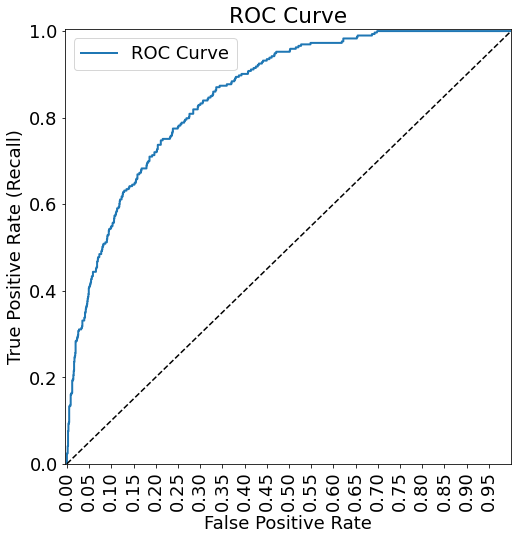

In [76]:
fpr, tpr, auc_thresholds = metrics.roc_curve(bt_df['y_true'], bt_df['y_score'])
plot_roc_curve(fpr, tpr, 'ROC Curve')

## Precision Recall Curve

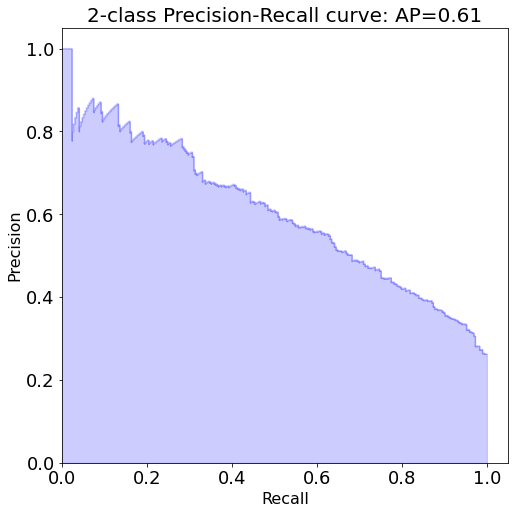

In [77]:
plot_prc(bt_df['y_score'], bt_df['y_true'])

## Threshold (Operating Point) Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          1085         93
Non-Compliant       148        145

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.88      0.92      0.90      1178
Non-Compliant       0.61      0.49      0.55       293

     accuracy                           0.84      1471
    macro avg       0.74      0.71      0.72      1471
 weighted avg       0.83      0.84      0.83      1471

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          1097         81
Non-Compliant       156        137

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.88      0.93      0.90      1178
Non-Compliant       0.63      0.47      0.54       293

     accuracy                           0.84      1471
    macro avg       0.75      0.70      0.72      1471
 weighted avg       0.83      0.84      0.83  

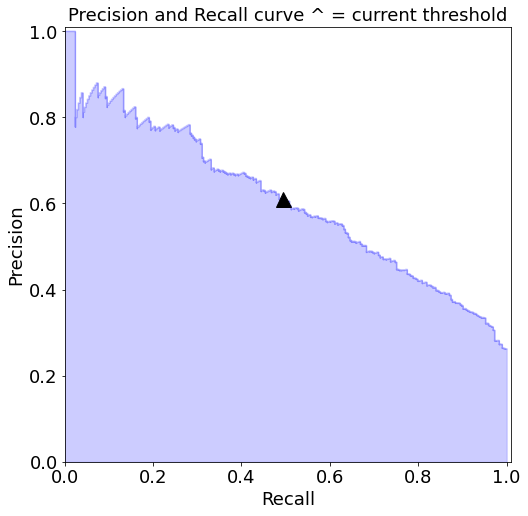

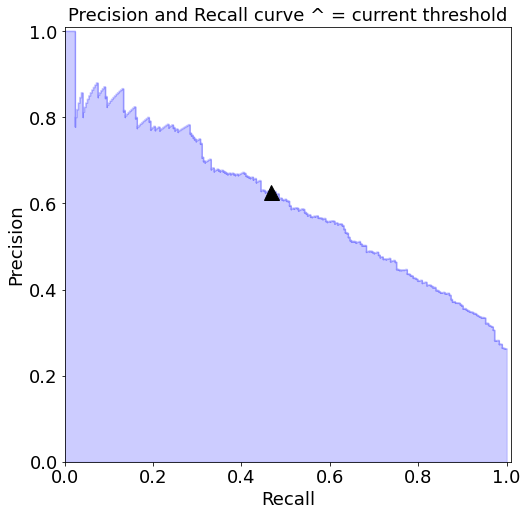

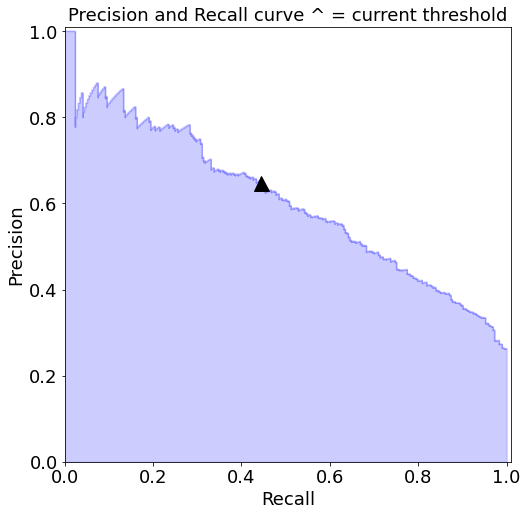

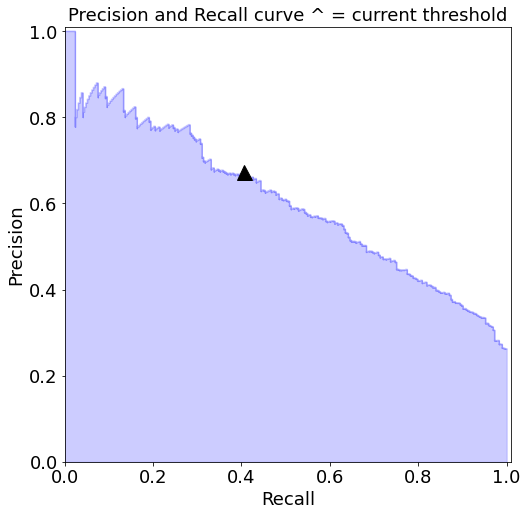

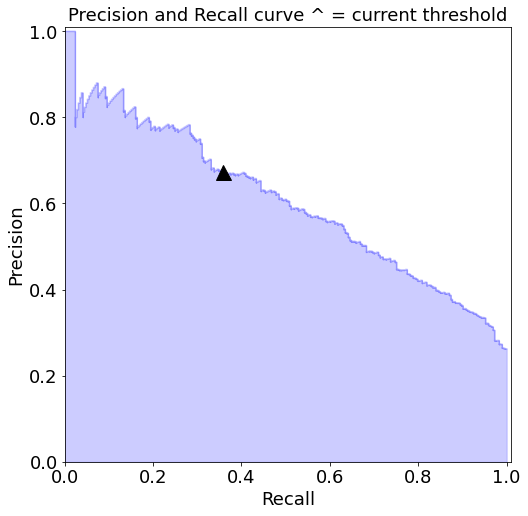

In [78]:
p, r, thresholds = metrics.precision_recall_curve(bt_df['y_true'], bt_df['y_score'])
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, bt_df['y_score'], bt_df['y_true'], t=i)

# Optimal Operating Point

Optimal Operating Point: 0.3023853898048401


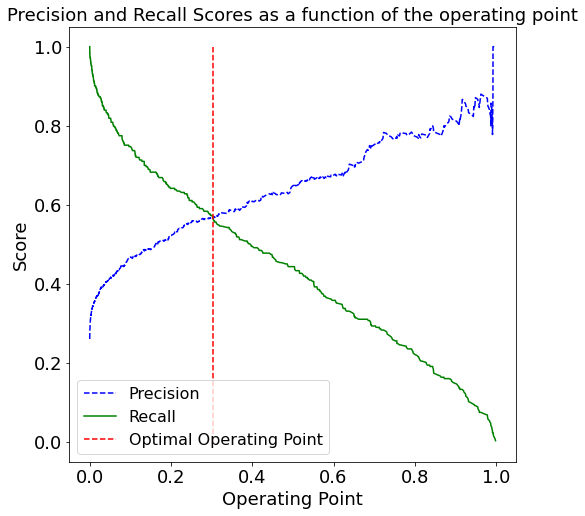

In [79]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

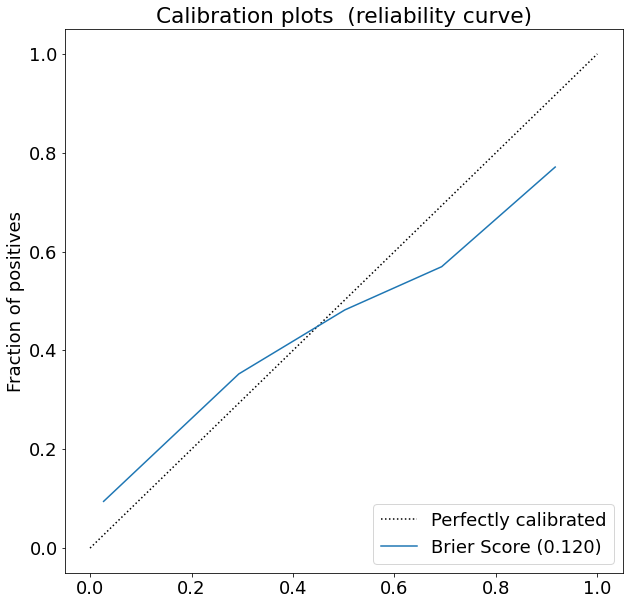

In [80]:
plot_calibration_curve(bt_df['y_true'], bt_df['y_score'])

## Adjusting to the Optimal Operating Point

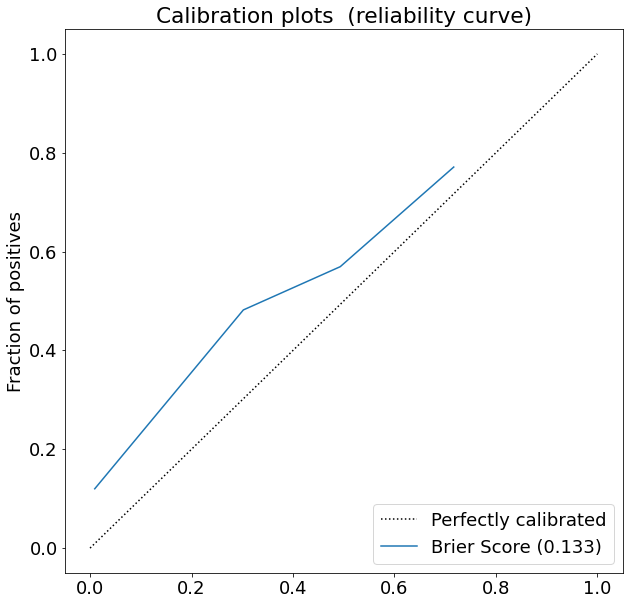

In [84]:
plot_calibration_curve(
    bt_df['y_true'],
    np.clip(bt_df['y_score'] - .2 , 0, 1)
)

In [85]:
# before adjustment
metrics.f1_score(bt_df['y_true'], bt_df['y_pred'])

0.5273833671399595

In [87]:
adjusted_y_pred = [0 if i < .5 else 1 for i in np.clip(bt_df['y_score'] - .2, 0, 1)]
metrics.f1_score(bt_df['y_true'], adjusted_y_pred)

0.42260442260442255

We get a slight improvement to the f1-score and a loss in the brier score, which I'd say is well worth it.

## Feature Importance
The word-embedding model doesn't provide a straightforward method to visualize feature importances like the tf-idf models. For those other models, it's possible to map each input word its location in the tf-idf matrix and then to use the index from that matrix to find the associated weight in the model.

Since a word embedding model uses a hidden layer neural network architecture, this isn't possible, although it is still a probababilistic model due to the final softmax layer. 

To get an idea for how individual words influenced a prediction, we need to think about the distance (in a hyper-plane) between individual words' word embedding representations and the mean tf-idf weighted word embedding vector of all of the positive samples in the training data set. 

To do this, we can use the cosine similarity as our distance metric. Intuitively, this will determine how similar each word in a clause is to the corpus of non-compliant clauses. The cosine similarity value can be interpreted as follows:

 - −1 value will indicate strongly opposite vectors
 - 0 independent (orthogonal) vectors
 - 1 similar (positive co-linear) vectors. Intermediate values are used to assess the degree of similarity.

In [89]:
X_test

0       Cost-Benefit Ratio, which is the alternative’s...
1       Section 16 of the Agreement is modified in its...
2       “Professional Services” means the training or ...
3       (c) the Indemnified Party undertakes no action...
4       Assignment. Each Party will be entitled to ass...
                              ...                        
1466    8        TERM & TERMINATION \n8.1        With ...
1467    Restrictions. COMPANY reserves any and all rig...
1468    1. Services. 1.1 Provision of Services. Compan...
1469    4.\tIncidental Expenses\nCustomer shall reimbu...
1470    THE COMPANY warrants that the SOFTWARE  will, ...
Name: Clause Text, Length: 1471, dtype: object

In [96]:
vec = TfidfVectorizer(tokenizer=lambda x: model.get_line(x)[0])
samples = [c.replace("\n", "") for c in bt_X_test.tolist()]
vec.fit(samples)
X = vec.transform(samples)

feature_names = vec.get_feature_names()

In [97]:
with open('vec.pkl', 'wb') as f:
    pickle.dump(vec, f)

In [98]:
sentence_vectors = []

mean_clause_vecs = []
for i, clause in enumerate(samples):
    tokens = model.get_line(clause)[0]
    clause_token_vecs = []
    
    feature_index = X[i, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[i, x] for x in feature_index])
    token_tfidf_map = {feature_names[i]: s for i, s in tfidf_scores}
    
    for token in tokens:
        token_vec = model.get_word_vector(token).reshape(1, -1)
        tf_idf_weight = token_tfidf_map[token]
        token_vec *= tf_idf_weight
        clause_token_vecs.append(token_vec)
    mean_clause_vec = np.mean(clause_token_vecs, axis=0)
    mean_clause_vecs.append(mean_clause_vec)

In [99]:
mean_vec = np.mean(mean_clause_vecs, axis=0)

In [100]:
np.save("mean_pos_sample_tfidf_vec.npy", mean_vec)

In [101]:
test_sentence = bt_X_test.tolist()[0]

token_to_sim = []
for token in model.get_line(test_sentence)[0]:
    
    token_vec = model.get_word_vector(token).reshape(1, -1)
    
    dense_token_tfidf_vec = vec.transform([token]).todense()
    token_tfidf = np.where(dense_token_tfidf_vec>0)[-1][-1]
    token_vec *= token_tfidf
    
    sim = metrics.pairwise.cosine_similarity(
        mean_vec.reshape(1, -1),
        token_vec   
    )
    
    token_to_sim.append((token, sim))

In [102]:
token_to_sim

[('cost-benefit', array([[0.]], dtype=float32)),
 ('ratio', array([[0.88779074]], dtype=float32)),
 (',', array([[0.34009245]], dtype=float32)),
 ('which', array([[0.99827754]], dtype=float32)),
 ('is', array([[-0.99657655]], dtype=float32)),
 ('the', array([[-0.5282796]], dtype=float32)),
 ('alternative', array([[0.83956075]], dtype=float32)),
 ('’', array([[0.9921638]], dtype=float32)),
 ('s', array([[-0.9928548]], dtype=float32)),
 ('priority', array([[0.46249884]], dtype=float32)),
 ('score', array([[0.98939204]], dtype=float32)),
 ('divided', array([[0.86835057]], dtype=float32)),
 ('into', array([[0.8901614]], dtype=float32)),
 ('its', array([[-0.97266805]], dtype=float32)),
 ('cost', array([[0.39856145]], dtype=float32)),
 ('.', array([[0.9959198]], dtype=float32)),
 ('a', array([[-0.92013514]], dtype=float32)),
 ('higher', array([[-0.9907213]], dtype=float32)),
 ('benefit-cost', array([[0.]], dtype=float32)),
 ('ratio', array([[0.88779074]], dtype=float32)),
 ('in', array([[0.9

We now have a mapping of tokens and the cosine similarity between their tf-idf weighted word embedding and that of  the corpus of positive samples. This allows to to back into the hidden layer's decision process.

In [103]:
elems = ''

for token, sim in token_to_sim:
    sim = sim[0][0]
    opacity = np.clip(abs(sim), .5, 1)
    hue = 0 if sim < 0 else 120
    lightness = np.clip(round(1 - abs(sim), 2) * 100, 50, 97)
    
    elem = (
        f'<span style="background-color: hsl({hue}, 100.00%, {lightness}%);'
        f' opacity: {opacity}" title="{sim}">{token}</span>'
    )
    
    elems += elem + ' '


display(HTML(elems))

# VotingClassifier
Out of curiosity, lets see how a majority vote from the three sklearn models works.

In [ ]:
sgd = joblib.load(os.path.join("estimators", "sgd.joblib"))
gbc = joblib.load(os.path.join("estimators", "gbc.joblib"))
rfc = joblib.load(os.path.join("estimators", "rfc.joblib"))

In [8]:
sgd_y_pred = sgd.predict(X_test)
sgd_y_score = sgd.predict_proba(X_test)[:,1]

rfc_y_pred = rfc.predict(X_test)
rfc_y_score = rfc.predict_proba(X_test)[:,1]

gbc_y_pred = gbc.predict(X_test)
gbc_y_score = gbc.predict_proba(X_test)[:,1]

In [18]:
voted_preds = []
for prediction in zip(sgd_y_pred, rfc_y_pred, gbc_y_pred):
    voted_preds.append(max(set(prediction), key=prediction.count))
    
voted_probs = []
for prob in zip(sgd_y_score, rfc_y_score, gbc_y_score):
    voted_probs.append(np.mean(prob))

In [22]:
print_results(y_test, voted_preds, voted_probs)

********************************************************************************
Recall:  0.67
Accuracy:  0.81
F1:  0.59
Brier Score:  0.12
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.91      0.85      0.88      1178
NonCompliant       0.52      0.67      0.59       293

    accuracy                           0.81      1471
   macro avg       0.72      0.76      0.73      1471
weighted avg       0.83      0.81      0.82      1471



There's an improvement in the brier-score with only a 1% drop in the F1 score when you compare this to the SGD model alone. Let's be a little smarter and use the prediction probability to weight predctions before choosing the majority, the intuition being that we should pay more attention to confident predictions than boderline ones.

In [44]:
weighted_preds = []
for preds, scores in zip(zip(sgd_y_pred, rfc_y_pred, gbc_y_pred), zip(sgd_y_score, rfc_y_score, gbc_y_score)):
    weighted_preds.append(np.mean((np.array(preds) + 1) * (np.array(scores) + 1)))

In [45]:
from sklearn.preprocessing import minmax_scale

weighted_preds = [0 if x < .5 else 1 for x in minmax_scale(weighted_preds)]

In [46]:
print_results(y_test, weighted_preds, minmax_scale(weighted_preds))

********************************************************************************
Recall:  0.67
Accuracy:  0.81
F1:  0.58
Brier Score:  0.19
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

   Compliant       0.91      0.85      0.88      1178
NonCompliant       0.52      0.67      0.58       293

    accuracy                           0.81      1471
   macro avg       0.71      0.76      0.73      1471
weighted avg       0.83      0.81      0.82      1471



that didn't really help, likely due to the already somewhat high baseline brier score.

# Summary

The Linear Model learned with Stochastic Gradient Descent appears to be the winner, so that model will be trained on the entirety of the data, using cross-validation, and then used to generate predictions on the validation dataset.